In [2]:
using PyPlot, SampledSignals, DSP, Statistics, FixedPointNumbers, PyCall, Polynomials, Conda

In [3]:
fa = 40000
f0 = 100π
t = 0:1/fa:3
A1 = 0.5
A2 = 0.3
A3 = 0.15
B0 = 5

s = A1*cos.(2π*f0*t)+A2*cos.(4π*300t)+A3*cos.(6π*f0*t);

In [4]:
sq = Fixed{Int16, B0-1}.(s)
yq = SampleBuf(sq,fa)

120001-frame, 1-channel SampleBuf{Q11f4, 1}
3.000025s sampled at 40000.0Hz
▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇

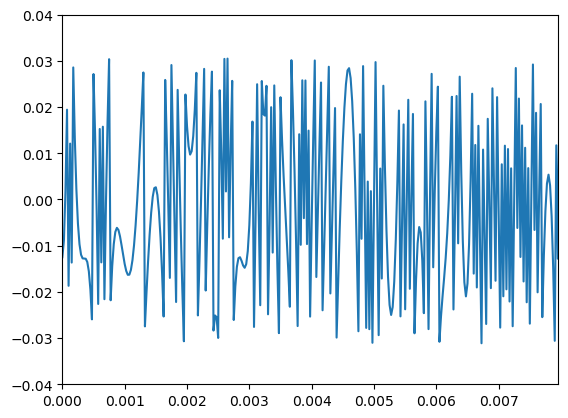

(0.0, 0.007957747154594767, -0.04, 0.04)

In [5]:
plot(t, sq-s)
axis([0,1/(40*pi),-0.04,0.04])

In [6]:
#Cálculo do SNR
PotSinal = A1^2/2 + A2^2/2 + A3^2/2
B0 = 5
σ20 = (2.0^(-2*B0))/3
SNR = pow2db(PotSinal/(σ20))

27.456992266025058

In [7]:
#Filtro IIR
δp = 0.05
ωp = 2π*3*f0/fa
ωr = 1.2*ωp
ωc = (ωp+ωr)/2

Ap = -20*log10(1-δp)
Ar = 40

δr = 10^(-Ar/20);

In [8]:
using Pkg
ENV["PYTHON"]=""
Pkg.build("PyCall")

sig = pyimport("scipy.signal")
N, Wn = sig.ellipord(ωp/π, ωr/π, Ap, Ar)

    Building Conda ─→ `C:\Users\jean_\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\6e47d11ea2776bc5627421d59cdcc1296c058071\build.log`
    Building PyCall → `C:\Users\jean_\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\1fc929f47d7c151c839c5fc1375929766fb8edcc\build.log`


(6, 0.0471238898038469)

In [9]:
zpkellip = digitalfilter(Lowpass(Wn), Elliptic(N, -20*log10(1-δp),-20*log10(δr)));
a = coefa(zpkellip);
b = coefb(zpkellip);

7-element Vector{Float64}:
  0.00975282107070694
 -0.05576936965803365
  0.13545792920680758
 -0.17888031756252204
  0.13545792920680755
 -0.05576936965803365
  0.009752821070706939

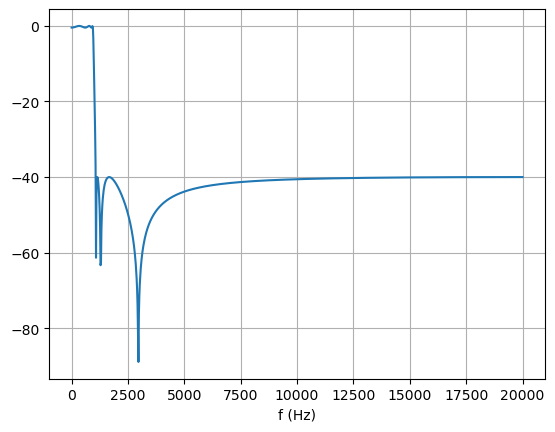

In [35]:
ω=range(0,π,length=1000)
H=freqz(zpkellip,ω);
plot(ω*fa/(2π), amp2db.(abs.(H)))
grid()
xlabel("f (Hz)");

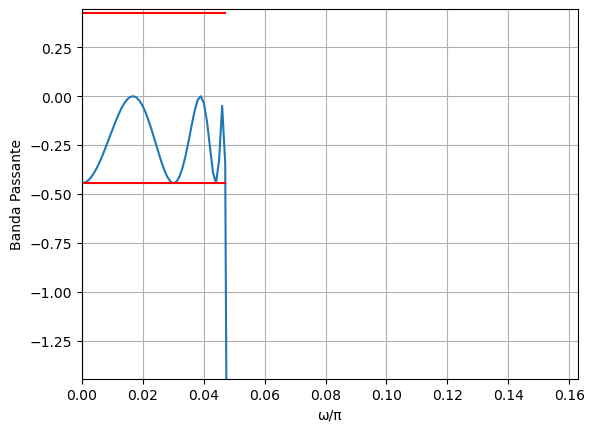

PyObject Text(24.0, 0.5, 'Banda Passante')

In [36]:
#Verificação dos requisitos
plot(ω./pi,amp2db.(abs.(H)))
plot([0;ωp/π],20*log10.([1-δp;1-δp]),color="red")
plot([0;ωp/π],20*log10.([1+δp;1+δp]),color="red")
axis([0,1.1*ωp,-Ap-1,Ap])
grid()
xlabel("ω/π")
ylabel("Banda Passante")

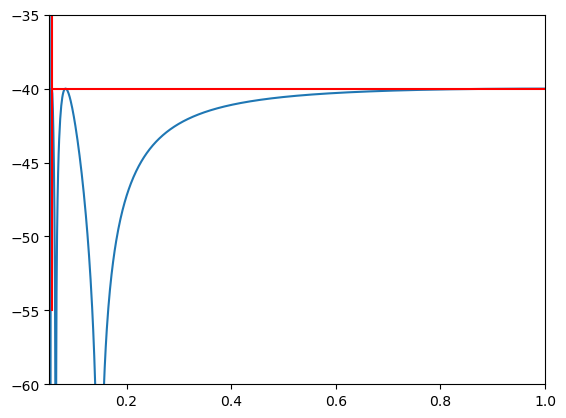

(0.05183627878423159, 1.0, -60.0, -35.0)

In [37]:
#Verificação dos requisitos
plot(ω./pi,amp2db.(abs.(H)))
plot([ωr;π]/π,20*log10.([δr;δr]),color="red")
plot([ωr;ωr]/π,[-Ar-15;5],color="red")
axis([ωc/π, 1, -Ar-20, -Ar+5])

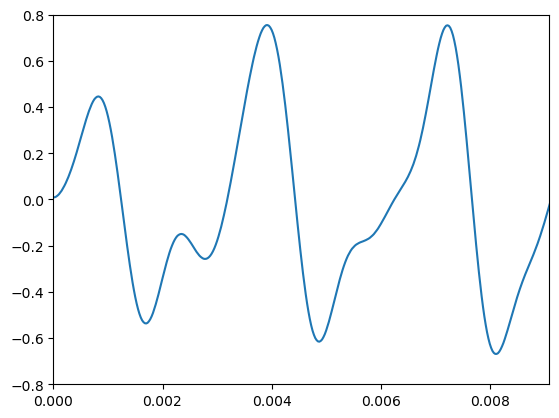

(0.0, 0.009094568176679734, -0.8, 0.8)

In [38]:
sqf = filt(b,a,sq)
plot(t, sqf)
axis([0,1/(35*pi),-0.8,0.8])

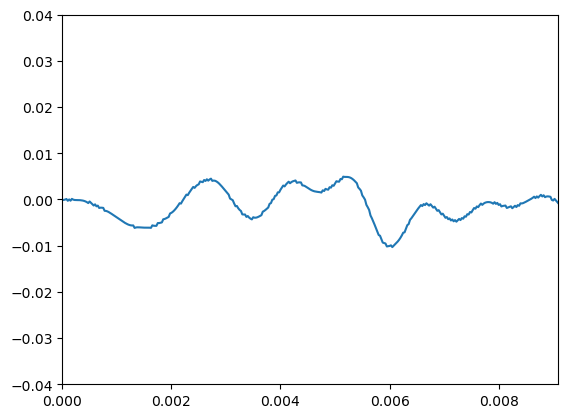

(0.0, 0.009094568176679734, -0.04, 0.04)

In [39]:
sf = filt(b,a,s)
plot(t, sqf-sf)
axis([0,1/(35*pi),-0.04,0.04])

In [15]:
#Cálculo do SNR da saída
PotRuido = σ20*sum(impz(zpkellip,500).^2)
SNRsaida = pow2db(PotSinal/PotRuido)
print(SNRsaida, " dB")

40.84616813469922 dB

In [64]:
#Ex5
include("fxfilt.jl")
B=12
Bc = 12
aq = Fixed{Int64,Bc-1}.(a)
bq = Fixed{Int64,Bc-1}.(b)

sqqf=fxfilt(bq,aq,Fixed{Int128,B-1}.(sq), true)

120001-element Array{Q116f11,1} with eltype Fixed{Int128, 11}:
  0.0093Q116f11
  0.0107Q116f11
  0.0161Q116f11
  0.0269Q116f11
  0.0444Q116f11
  0.0728Q116f11
  0.1138Q116f11
  0.1724Q116f11
  0.251Q116f11
  0.3535Q116f11
  0.4824Q116f11
  0.6392Q116f11
  0.8237Q116f11
  ⋮
 -3.706235497479736e31Q116f11
 -2.746179574576061e31Q116f11
 -3.982028731355213e31Q116f11
 -3.278294010261174e31Q116f11
  1.896783919517735e31Q116f11
 -3.6404666965303355e31Q116f11
 -5.036620772494466e30Q116f11
  1.9855042373700998e31Q116f11
  3.2839003798421494e31Q116f11
  2.138864531787052e31Q116f11
 -3.227749416031051e31Q116f11
  1.2977061678556155e31Q116f11

In [25]:
σ2=2.0^(-2*B)/3
PotRuido3 = σ20*sum(impz(hq,500).^2) + σ2*sum(impz(1,aq).^2);
#PotRuido_Pratico = var(sq_pf-sq_f)

LoadError: MethodError: no method matching impz(::Vector{Q51f12}, ::Vector{Q52f11})
[0mClosest candidates are:
[0m  impz([91m::FilterCoefficients{:z}[39m, ::Any) at C:\Users\jean_\AppData\Local\Programs\Julia-1.7.2\share\julia\base\deprecated.jl:70